In [2]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [5]:
user,item,title = 'userId','movieId','title'

In [6]:
path = untar_data(URLs.ML_SAMPLE)
path

WindowsPath('C:/Users/Harpal/.fastai/data/movie_lens_sample')

In [7]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss
1,1.646060,0.997627
2,0.861574,0.683204
3,0.650477,0.674427


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [10]:
path=Config.data_path()/'ml-100k'

In [11]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
len(ratings)

100000

In [14]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [15]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name=title)

In [16]:
data.show_batch()

userId,title,target
42,Conan the Barbarian (1981),2.0
692,Young Frankenstein (1974),4.0
870,Better Off Dead... (1985),3.0
58,Beavis and Butt-head Do America (1996),4.0
58,Mute Witness (1994),4.0


Makes the final version a sigmoid. Scales the final value between 0 - 5.5. Movies can be rated betweem 0 and 5 and becuase a sigmoid never reaches 0 or 5 we add a little extrax to the `y_range` hence the 5.5. Why not -0.5? for the minimum? The scale of the training data is 0.5 - 5 hence 0 is okay for the minimum.


In [17]:
y_range = [0,5.5]

In [18]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


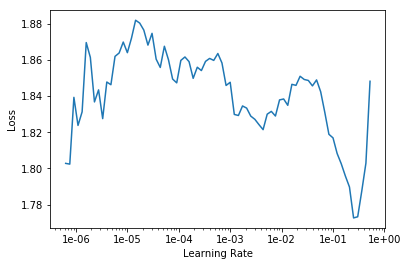

In [19]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [20]:
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss
1,2.173161,2.323677
2,2.760745,2.788571
3,1.925843,1.896327
4,1.092451,1.078434
5,0.818780,0.881394


In [21]:
learn.save('dotprod')

Validations loss here is MSE

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [22]:
learn.load('dotprod');

In [23]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

Get top 1000 most commonly rated movies

In [24]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

Extract the move biases (lesson 5 of course v3)

In [25]:
# is_item=True Biases of items (this case Movies)
# is_item=False Biases for users
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [26]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [27]:
item0 = lambda o:o[0]

A low bias here bias represents the poorly rated movies

In [28]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.6163),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.5743),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.5562), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.5299), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.5197), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.5070), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.4997), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.4758), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.4565), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.4564), 'Booty Call (1997)', 2.1666666666666665),
 (tensor(-0.4400), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.4380), 'Tales from the Hood (1995)', 2.037037037037037),
 (tensor(-0.4344), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.4300), 'Free Willy 3: The Rescue (1997)', 1.740740740740740

A high bias here represents highly rated moveis

In [29]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(1.0343), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.9801), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.9402), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.9157), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.8879), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.8788), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.8495), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.8411), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.8369), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.8349), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.8266), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.8190), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.8067), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.8058), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.7910), 'Princess Bride, The (1987)', 4.172839506172839)]

### Movie weights

Output tensort will have 1000 rows becuase we extracted the 1000 most common movies

In [30]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

Compress the embeddings into 3 PCA components

In [31]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [32]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9578), 'Apocalypse Now (1979)'),
 (tensor(0.9407), 'Delicatessen (1991)'),
 (tensor(0.9210), 'Chinatown (1974)'),
 (tensor(0.8896), 'To Die For (1995)'),
 (tensor(0.8555), 'Lone Star (1996)'),
 (tensor(0.8494), '2001: A Space Odyssey (1968)'),
 (tensor(0.8476), 'Heavenly Creatures (1994)'),
 (tensor(0.8412), 'Clockwork Orange, A (1971)'),
 (tensor(0.8328), 'Ran (1985)'),
 (tensor(0.8183), "Miller's Crossing (1990)")]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9410), 'Jungle2Jungle (1997)'),
 (tensor(-0.9407), 'Ghost and the Darkness, The (1996)'),
 (tensor(-0.9262), 'Twister (1996)'),
 (tensor(-0.8725), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8597), 'Net, The (1995)'),
 (tensor(-0.8471), 'Michael (1996)'),
 (tensor(-0.7458), 'Just Cause (1995)'),
 (tensor(-0.7451), 'Batman Forever (1995)'),
 (tensor(-0.7430), 'Peacemaker, The (1997)'),
 (tensor(-0.7381), 'Saint, The (1997)')]

In [35]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [36]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8630), 'Field of Dreams (1989)'),
 (tensor(0.8119), 'Forrest Gump (1994)'),
 (tensor(0.7867), 'Dave (1993)'),
 (tensor(0.7504), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.7375), 'Die Hard (1988)'),
 (tensor(0.7291), 'Affair to Remember, An (1957)'),
 (tensor(0.6887), 'Miracle on 34th Street (1994)'),
 (tensor(0.6794), 'Aladdin (1992)'),
 (tensor(0.6550), 'Meet John Doe (1941)'),
 (tensor(0.6268), '12 Angry Men (1957)')]

In [37]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.7543), 'Beverly Hills Ninja (1997)'),
 (tensor(-0.7081), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.5926), 'Cook the Thief His Wife & Her Lover, The (1989)'),
 (tensor(-0.5584), 'Road to Wellville, The (1994)'),
 (tensor(-0.5455), 'Evil Dead II (1987)'),
 (tensor(-0.5400), 'Stealing Beauty (1996)'),
 (tensor(-0.5303), 'Black Sheep (1996)'),
 (tensor(-0.5268), 'Kull the Conqueror (1997)'),
 (tensor(-0.5244), 'Stupids, The (1996)'),
 (tensor(-0.5212), 'Showgirls (1995)')]

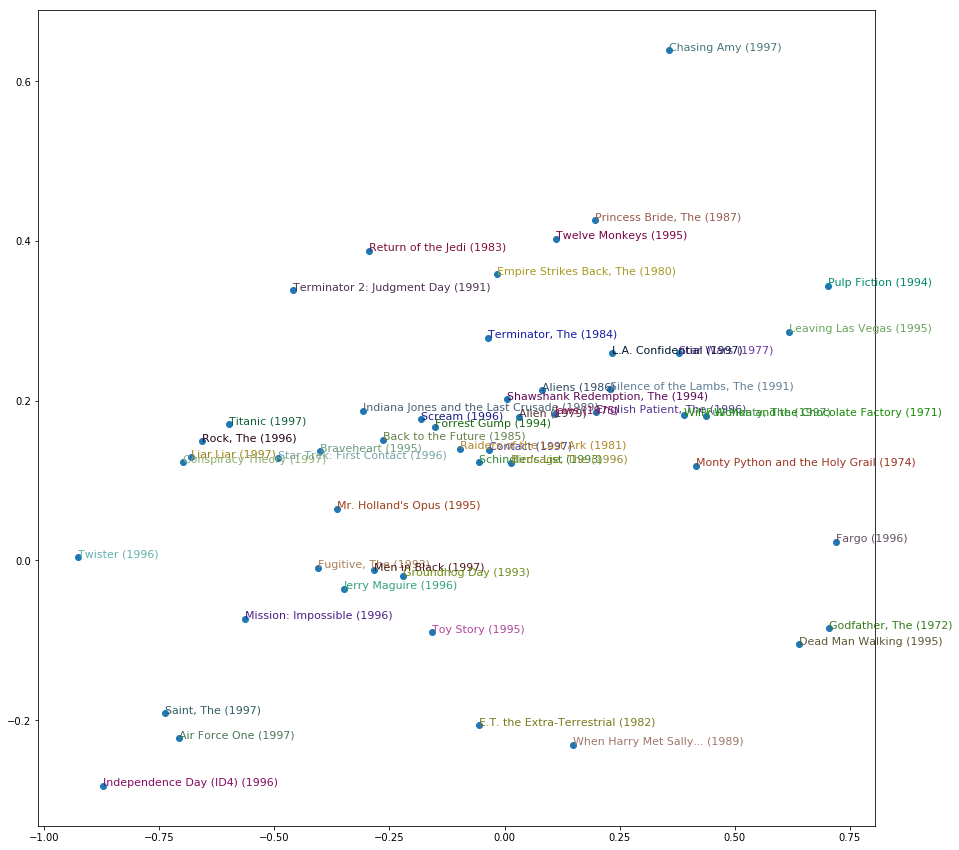

In [38]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()